In [1]:
import mne
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
n_channels = 8
ch_types = ['eeg'] * n_channels
sfreq = 250
ch_names = ["F3", "Fz", "F4", "C3", "Cz", "C4", "P3", "P4"]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
info.set_montage("standard_1020")

<Info | 8 non-empty values
 bads: []
 ch_names: F3, Fz, F4, C3, Cz, C4, P3, P4
 chs: 8 EEG
 custom_ref_applied: False
 dig: 11 items (3 Cardinal, 8 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 250.0 Hz
>

In [3]:
ga = 'datasets/Daniella Sehaber/Glucagon Ativo/OpenBCI-RAW-2023-10-26_12-43-47.txt'
gaOb = np.loadtxt(ga, delimiter=',', skiprows=5, usecols=range(1, 9))

basal = 'datasets/Daniella Sehaber/Glucagon Ativo/OpenBCI-RAW-2023-10-26_13-06-25.txt'
basalOb = np.loadtxt(ga, delimiter=',', skiprows=5, usecols=range(1, 9))

In [4]:
# Aula IA
gaIntervaloTempo = [
    "9:35 - 15:00",
]

# Basal (TF)
BasalIntervaloTempo = [
    "1:30 - 2:30"
]

In [5]:
import mne

def minutosParaSegundos(tempo):
    minutos, segundos = map(int, tempo.split(":"))
    return minutos * 60 + segundos

def converteIntervaloTempoParaIndice(intervaloTempo, sfreq):
    inicio, fim = map(str, intervaloTempo.split(" - "))
    novoInicio = minutosParaSegundos(inicio)
    novoFim = minutosParaSegundos(fim)
    
    indice = []
    indice.append(novoInicio * sfreq)
    indice.append(novoFim * sfreq)

    return indice

In [6]:
ga_index = []
ga_index = converteIntervaloTempoParaIndice(gaIntervaloTempo[0], 250)

basal_index = []
basal_index = converteIntervaloTempoParaIndice(BasalIntervaloTempo[0], 250)

recorteDadosGa = gaOb[ga_index[0]:ga_index[1], :]
recorteDadosBasal = basalOb[basal_index[0]:basal_index[1], :]

X = {
    'ga': mne.io.RawArray(recorteDadosGa.T, info),
    'basal': mne.io.RawArray(recorteDadosBasal.T, info),
}

Creating RawArray with float64 data, n_channels=8, n_times=81250
    Range : 0 ... 81249 =      0.000 ...   324.996 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.


In [7]:
# TODO: filtrar corretamente os dados que são usados para SNR (basal)

for key in X:
    X[key].notch_filter(freqs=60)
    X[key].filter(l_freq=4, h_freq=100)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband e

### Definição da janela deslizante

In [8]:
sr = 250            # Taxa de amostragem dos dados do EEG (250Hz)
jump = 5            # Tamanho da janela de análise (5 em 5 segundos)
size = sr * jump    # Número de pontos de dados em cada janela de análise

# Definindo os limites das bandas de frequência (em Hz)
theta_band = (4, 8)       # Theta: 4 - 8 Hz
alpha_band = (8, 13)      # Alpha: 8 - 13 Hz
beta_band = (13, 30)      # Beta: 13 - 30 Hz
gamma_band = (30, 100)    # Gamma: 30 - 100 Hz


samples = {
    'focus': [],
    'not_focus': []
}
total_pc = {}
data_names = ('ga',)

# Mapeamento de índices para rótulos
band_labels = {
    0: 'focus',
    1: 'not_focus',
}

for k, data in enumerate(X.values()): # TODO: obter apenas os dados da aula e não do basal
    results = [0, 0, 0, 0] # Contagem de dominância de cada banda
    labels = [] # Lista para armazenar os rótulos das janelas

    data.set_eeg_reference(ref_channels='average', projection=False)
    
    # Percorre os dados em incrementos de sr (1 segundo) extraindo janelas de tamanho size (4s)
    for i in range(0, int(data.times[-1] - jump), 1):
        tmin = i
        tmax = i + jump

        cut = data.copy().crop(tmin=tmin, tmax=tmax).get_data()

        # Número de pontos por segmento
        n_per_seg = 128
        # Quantidade de sobreposição entre segmentos
        n_overlap = n_per_seg // 2 # 64
        
        # Calculando a densidade espectral de potência (PSD)
        freqs, psd = welch(cut, fs=sr, nperseg=n_per_seg, noverlap=n_overlap)
        
        # realizando a média dos 8 eletrodos
        # transformando em um ndarray unidimensional
        X_avg = np.average(psd, axis=0)

        # Encontrar os índices correspondentes às frequências de interesse
        theta_idxs = np.where((freqs >= theta_band[0]) & (freqs <= theta_band[1]))[0]
        alpha_idxs = np.where((freqs >= alpha_band[0]) & (freqs <= alpha_band[1]))[0]
        beta_idxs = np.where((freqs >= beta_band[0]) & (freqs <= beta_band[1]))[0]
        gamma_idxs = np.where((freqs >= gamma_band[0]) & (freqs <= gamma_band[1]))[0]

        # Calculando a potência em cada banda de frequência por meio da integração da PSD
        bands = [
            np.sum(X_avg[theta_idxs]),
            np.sum(X_avg[alpha_idxs]),
            np.sum(X_avg[beta_idxs]),
            np.sum(X_avg[gamma_idxs])
        ]
        
        # Determina qual banda é a dominante (maior potência)
        dominant_band = np.argmax(bands)
        
        # Calculando a pontuação de cada banda para mostrar a porcentagem
        results[dominant_band] += 1
        
        if dominant_band == 2 or dominant_band == 3:
            samples['focus'].append(X_avg)
        else:
            samples['not_focus'].append(X_avg)

        # Adicionando o rótulo correspondente
        # labels.append(band_labels.get(dominant_band))

    # total = sum(results)
    # percentages = [round((count/total) * 100, 2) for count in results]
    # print(data.__str__())
    # total_pc[data_names[k]] = percentages

# print(total_pc)
print(samples)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
{'focus': [array([1.14395560e-01, 8.13523628e-01, 2.66857211e+00, 2.39544789e+00,
       1.21640652e+00, 7.59392226e-01, 6.68993863e-01, 6.28868922e-01,
       6.53365690e-01, 7.60004541e-01, 6.53628087e-01, 5.36273106e-01,
       4.18303172e-01, 4.09674434e-01, 3.58347462e-01, 3.13067493e-01,
       2.28758106e-01, 1.60192015e-01, 1.07908833e-01, 1.19235445e-01,
       1.17592314e-01, 1.10009712e-01, 1.12299736e-01, 1.20506312e-01,
       1.26312129e-01, 1.30766778e-01, 1.37702235e-01, 1.16922311e-01,
       9.15742546e-02, 9.66168178e-02, 8.40117560e-02, 6.47588810e-02,
       6.31575736e-02, 7.13416952e-02, 5.36644350e-02, 4.55072095e-02,
       3.76145596e-02, 4.22068393e-02, 4.62984997e-02, 3.59593633e-02,
       4.12969334e-02, 4.40922419e-02, 3.57219577e-02, 2.

In [9]:
import numpy as np
from scipy.signal import welch

# TODO um for
# array de ndarrays
# para cada ndarray de ndarrays
# Convertendo o tipo dos dados filtrados de objeto RawArray para ndarray

ndarray_data_basal = X['basal'].copy().get_data()

# Transformando os dados de basal para o domínio da frequência
_, data_basal_frequency = welch(ndarray_data_basal, fs=250, nperseg=512, noverlap=256)

# Lista que armazena as médias de potência para cada canal
noise_power = []

for channel_data in data_basal_frequency:
    # média da potência no intervalo de tempo sem estímulo
    base_power = np.mean(channel_data)
    noise_power.append(base_power)

# média das médias de potência de todos os canais para estimar o ruído de fundo
estimated_background_noise = np.mean(noise_power)
print("Estimated background noise:", estimated_background_noise)

# Ajustando os dados para o cálculo do SNR
# Supondo que `target_amplitudes_adjusted` deve ser uma matriz que contém os dados ajustados
# Precisamos garantir que esta variável seja definida. Vou assumir que você tem algo semelhante.
# Ajuste `target_amplitudes_adjusted` com base em seus dados.

# Exemplo fictício de target_amplitudes_adjusted
target_amplitudes_adjusted = np.array(data_basal_frequency) - estimated_background_noise

# Calculando o SNR para cada canal
narrow_band_SNR = 10 * np.log10(np.mean(target_amplitudes_adjusted, axis=1) / estimated_background_noise)
print("Narrow Band SNR:", narrow_band_SNR)
print("Shape:", narrow_band_SNR.shape)

# Calculando o SNR de banda larga
total_power = np.sum(target_amplitudes_adjusted, axis=1)
wide_band_SNR = 10 * np.log10(total_power / estimated_background_noise)
print("Wide Band SNR:", wide_band_SNR)
print("Shape:", wide_band_SNR.shape)

Estimated background noise: 6033.586309431702
Narrow Band SNR: [       nan        nan        nan        nan        nan 7.65263244
        nan        nan]
Shape: (8,)
Wide Band SNR: [        nan         nan         nan         nan         nan 31.75196367
         nan         nan]
Shape: (8,)


/tmp/ipykernel_40399/2477179357.py:35: RuntimeWarning: invalid value encountered in log10
  narrow_band_SNR = 10 * np.log10(np.mean(target_amplitudes_adjusted, axis=1) / estimated_background_noise)
/tmp/ipykernel_40399/2477179357.py:41: RuntimeWarning: invalid value encountered in log10
  wide_band_SNR = 10 * np.log10(total_power / estimated_background_noise)


In [10]:
# Função para calcular o SNR
def calculate_snr(data, fs=250, nperseg=512, noverlap=256):
    # Transformando os dados para o domínio da frequência
    _, data_frequency = welch(data, fs=fs, nperseg=nperseg, noverlap=noverlap)
    
    # Lista que armazena as médias de potência para cada canal
    noise_power = []

    for channel_data in data_frequency:
        # Média da potência no intervalo de tempo sem estímulo
        base_power = np.mean(channel_data)
        noise_power.append(base_power)

    # Média das médias de potência de todos os canais para estimar o ruído de fundo
    estimated_background_noise = np.mean(noise_power)
    
    # Ajustando os dados para o cálculo do SNR
    target_amplitudes_adjusted = np.array(data_frequency) - estimated_background_noise
    
    # Calculando o SNR para cada canal
    narrow_band_SNR = 10 * np.log10(np.mean(target_amplitudes_adjusted, axis=1) / estimated_background_noise)
    
    # Calculando o SNR de banda larga
    total_power = np.sum(target_amplitudes_adjusted, axis=1)
    wide_band_SNR = 10 * np.log10(total_power / estimated_background_noise)
    
    return narrow_band_SNR, wide_band_SNR

# Suponha que você tenha uma lista de ndarrays
data_list = [ndarray_data_basal]  # Adicione seus ndarrays aqui

# Processar cada ndarray na lista
for i, data in enumerate(data_list):
    print(f"Processing data {i+1}...")
    narrow_band_SNR, wide_band_SNR = calculate_snr(data)
    
    print(f"Narrow Band SNR for data {i+1}:")
    print(narrow_band_SNR)
    print(f"Shape: {narrow_band_SNR.shape}")
    
    print(f"Wide Band SNR for data {i+1}:")
    print(wide_band_SNR)
    print(f"Shape: {wide_band_SNR.shape}")


Processing data 1...
Narrow Band SNR for data 1:
[       nan        nan        nan        nan        nan 7.65263244
        nan        nan]
Shape: (8,)
Wide Band SNR for data 1:
[        nan         nan         nan         nan         nan 31.75196367
         nan         nan]
Shape: (8,)


/tmp/ipykernel_40399/3593252261.py:21: RuntimeWarning: invalid value encountered in log10
  narrow_band_SNR = 10 * np.log10(np.mean(target_amplitudes_adjusted, axis=1) / estimated_background_noise)
/tmp/ipykernel_40399/3593252261.py:25: RuntimeWarning: invalid value encountered in log10
  wide_band_SNR = 10 * np.log10(total_power / estimated_background_noise)


In [11]:
import mne
import numpy as np
from scipy.signal import welch

# Configurações
sr = 250            # Taxa de amostragem dos dados do EEG (250Hz)
jump = 5            # Tamanho da janela de análise (5 segundos)
size = sr * jump    # Número de pontos de dados em cada janela de análise

# Definindo os limites das bandas de frequência (em Hz)
theta_band = (4, 8)       # Theta: 4 - 8 Hz
alpha_band = (8, 13)      # Alpha: 8 - 13 Hz
beta_band = (13, 30)      # Beta: 13 - 30 Hz
gamma_band = (30, 100)    # Gamma: 30 - 100 Hz

total_pc = {}
data_names = ('ga',)  # Lista com um único item

# Mapeamento de índices para rótulos
band_labels = {
    0: 'Theta',
    1: 'Alpha',
    2: 'Beta',
    3: 'Gamma'
}

for k, data in enumerate(X.values()):
    # Verifique se a chave existe
    if k >= len(data_names):
        print(f"Índice {k} fora do intervalo para data_names.")
        continue

    results = [0, 0, 0, 0]  # Contagem de dominância de cada banda
    labels = []  # Lista para armazenar os rótulos das janelas

    data.set_eeg_reference(ref_channels='average', projection=False)
    
    # Percorre os dados em incrementos de 1 segundo extraindo janelas de tamanho `jump` (5 segundos)
    for i in range(0, int(data.times[-1] - jump), 1):
        tmin = i
        tmax = i + jump

        cut = data.copy().crop(tmin=tmin, tmax=tmax).get_data()

        # Número de pontos por segmento
        n_per_seg = 128
        # Quantidade de sobreposição entre segmentos
        n_overlap = n_per_seg // 2  # 64
        
        # Calculando a densidade espectral de potência (PSD)
        freqs, psd = welch(cut, fs=sr, nperseg=n_per_seg, noverlap=n_overlap)
        
        # realizando a média dos 8 eletrodos
        X_avg = np.average(psd, axis=0)

        # Encontrar os índices correspondentes às frequências de interesse
        theta_idxs = np.where((freqs >= theta_band[0]) & (freqs <= theta_band[1]))[0]
        alpha_idxs = np.where((freqs >= alpha_band[0]) & (freqs <= alpha_band[1]))[0]
        beta_idxs = np.where((freqs >= beta_band[0]) & (freqs <= beta_band[1]))[0]
        gamma_idxs = np.where((freqs >= gamma_band[0]) & (freqs <= gamma_band[1]))[0]

        # Calculando a potência em cada banda de frequência por meio da integração da PSD
        bands = [
            np.sum(X_avg[theta_idxs]),
            np.sum(X_avg[alpha_idxs]),
            np.sum(X_avg[beta_idxs]),
            np.sum(X_avg[gamma_idxs])
        ]
        
        # Determina qual banda é a dominante (maior potência)
        dominant_band = np.argmax(bands)
        
        # Calculando a pontuação de cada banda para mostrar a porcentagem
        results[dominant_band] += 1

        # Adiciona o rótulo correspondente, ou 'Não Focado' se não houver correspondência
        labels.append(band_labels.get(dominant_band, 'Não Focado'))

    # Armazenar os rótulos e porcentagens finais
    if data_names[k] not in total_pc:
        total_pc[data_names[k]] = {
            'Theta': labels.count('Theta'),
            'Beta': labels.count('Beta'),
            'Gamma': labels.count('Gamma'),
            'Não Focado': labels.count('Não Focado')
        }
    else:
        print(f"Chave {data_names[k]} já existe em total_pc.")

print(total_pc)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Índice 1 fora do intervalo para data_names.
{'ga': {'Theta': 39, 'Beta': 270, 'Gamma': 10, 'Não Focado': 0}}


## Classificação de Dados EEG com SVM

Este código demonstra como preparar dados de EEG, treinar um classificador SVM (Support Vector Machine) e avaliar o desempenho do modelo. Abaixo está uma explicação detalhada de cada parte do código:

### 1. Preparação dos Dados

- **samples**: Um dicionário que contém duas listas de amostras de dados EEG:
  - `'focus'`: Amostras onde o cérebro está em estado de foco.
  - `'not_focus'`: Amostras onde o cérebro não está em estado de foco.

- **X**: Combina as amostras das duas condições (foco e não foco) em uma única matriz onde cada linha representa uma amostra.
- **y**: Vetor de rótulos correspondente a cada amostra em `X`. Aqui, `1` indica foco e `0` indica não foco.

### 2. Divisão dos Dados

- **train_test_split**: Função que divide os dados em conjuntos de treinamento e teste.
  - `X_train` e `y_train`: Dados e rótulos usados para treinar o modelo.
  - `X_test` e `y_test`: Dados e rótulos usados para avaliar o desempenho do modelo.
  - `test_size=0.2`: 20% dos dados são usados para teste, 80% para treinamento.
  - `random_state=42`: Define uma semente para garantir que a divisão dos dados seja reproduzível.

### 3. Criação e Treinamento do Modelo SVM

- **svm.SVC**: Cria um classificador SVM com um kernel linear.
- **clf.fit**: Treina o modelo com os dados de treinamento (`X_train` e `y_train`).

### 4. Avaliação do Modelo

- **clf.predict**: Faz previsões com base nos dados de teste (`X_test`).
- **classification_report**: Avalia o desempenho do modelo, fornecendo métricas como precisão, recall e F1-score para cada classe. As classes são rotuladas como `'Não Focado'` e `'Foco'`.

### Resultados Esperados

O relatório de classificação exibirá métricas de desempenho para o modelo, incluindo:
- **Precisão**: A proporção de previsões corretas entre as amostras previstas.
- **Recall**: A proporção de amostras corretas identificadas pelo modelo entre as amostras verdadeiras.
- **F1-Score**: A média harmônica entre precisão e recall, oferecendo uma única métrica de desempenho.

Este processo ajuda a avaliar a eficácia do modelo SVM na classificação de estados de foco e não foco com base nos dados de EEG.


In [12]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# `samples` é um dicionário com duas chaves: 'focus' e 'not_focus'
# Cada valor é uma lista de arrays, cada array é uma amostra da densidade espectral de potência (PSD)

# Convertendo o dicionário de amostras em arrays
X = np.vstack([samples['focus'], samples['not_focus']])
y = np.array([1] * len(samples['focus']) + [0] * len(samples['not_focus']))  # 1 para foco, 0 para não foco

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo SVM
clf = svm.SVC(kernel='linear')  # Você pode ajustar o kernel conforme necessário
clf.fit(X_train, y_train)

# Fazer previsões
y_pred = clf.predict(X_test)

# Avaliar o modelo
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Não Focado', 'Foco']))

Relatório de Classificação:
              precision    recall  f1-score   support

  Não Focado       0.88      0.78      0.82         9
        Foco       0.97      0.98      0.98        66

    accuracy                           0.96        75
   macro avg       0.92      0.88      0.90        75
weighted avg       0.96      0.96      0.96        75



## Relatório de Classificação Explicado

O relatório de classificação fornece métricas detalhadas sobre o desempenho do modelo SVM ao classificar os estados de foco e não foco com base nos dados de EEG. As métricas são apresentadas para cada classe (`Não Focado` e `Foco`), bem como médias gerais. Abaixo está uma explicação de cada métrica:

### Métricas para Cada Classe

1. **Não Focado**:
   - **Precisão (Precision)**: 0.88
     - A proporção de amostras corretamente classificadas como `Não Focado` entre todas as amostras classificadas como `Não Focado`. Significa que 88% das previsões de `Não Focado` são corretas.
   - **Recall**: 0.78
     - A proporção de amostras verdadeiramente `Não Focado` que foram corretamente identificadas pelo modelo. Significa que 78% das amostras `Não Focado` foram identificadas corretamente.
   - **F1-Score**: 0.82
     - A média harmônica entre precisão e recall, oferecendo uma métrica única que considera tanto a precisão quanto o recall. Um F1-Score de 0.82 indica um bom equilíbrio entre precisão e recall para a classe `Não Focado`.
   - **Support**: 9
     - O número de amostras reais da classe `Não Focado` no conjunto de teste.

2. **Foco**:
   - **Precisão (Precision)**: 0.97
     - A proporção de amostras corretamente classificadas como `Foco` entre todas as amostras classificadas como `Foco`. Significa que 97% das previsões de `Foco` são corretas.
   - **Recall**: 0.98
     - A proporção de amostras verdadeiramente `Foco` que foram corretamente identificadas pelo modelo. Significa que 98% das amostras `Foco` foram identificadas corretamente.
   - **F1-Score**: 0.98
     - A média harmônica entre precisão e recall para a classe `Foco`. Um F1-Score de 0.98 indica um excelente equilíbrio entre precisão e recall para a classe `Foco`.
   - **Support**: 66
     - O número de amostras reais da classe `Foco` no conjunto de teste.

### Métricas Gerais

- **Accuracy**: 0.96
  - A proporção total de previsões corretas (tanto `Foco` quanto `Não Focado`) entre todas as amostras no conjunto de teste. Um valor de 0.96 indica que o modelo acertou 96% das previsões.

- **Macro Avg (Média Macro)**:
  - **Precisão**: 0.92
    - A média das precisões de cada classe, sem considerar o suporte (tamanho das classes).
  - **Recall**: 0.88
    - A média dos recalls de cada classe, sem considerar o suporte.
  - **F1-Score**: 0.90
    - A média dos F1-Scores de cada classe, sem considerar o suporte.

- **Weighted Avg (Média Ponderada)**:
  - **Precisão**: 0.96
    - A precisão média ponderada pela proporção de amostras de cada classe.
  - **Recall**: 0.96
    - O recall médio ponderado pela proporção de amostras de cada classe.
  - **F1-Score**: 0.96
    - O F1-Score médio ponderado pela proporção de amostras de cada classe.

### Conclusão

O modelo SVM mostrou um desempenho muito bom na classificação de estados de foco e não foco. A precisão, recall e F1-Score são altos, especialmente para a classe `Foco`, indicando que o modelo é bastante eficaz na identificação de estados de foco. O relatório geral também mostra que o modelo tem uma alta precisão e recall em geral, com médias ponderadas e macro que confirmam a eficácia do modelo.


### Visualização da Eficácia do Modelo SVM
Para avaliar a eficácia do modelo de Support Vector Machine (SVM) que foi treinado para classificar estados de foco em EEG, criamos duas visualizações principais:

- Curva ROC: Esta curva ilustra o desempenho do modelo em diferentes limiares de decisão. A área sob a curva (AUC) é uma medida de quão bem o modelo consegue distinguir entre as classes. Um valor de AUC próximo de 1 indica um excelente desempenho, enquanto um valor próximo de 0.5 sugere que o modelo não tem habilidade discriminativa superior à aleatoriedade.

- Matriz de Confusão: A matriz de confusão fornece uma visão detalhada sobre o número de previsões corretas e incorretas feitas pelo modelo. Mostra a quantidade de verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos, ajudando a identificar como o modelo se comporta em relação a cada classe específica.

As visualizações ajudam a entender não apenas a acurácia global do modelo, mas também como ele lida com cada classe individualmente e como seu desempenho varia com diferentes limiares.









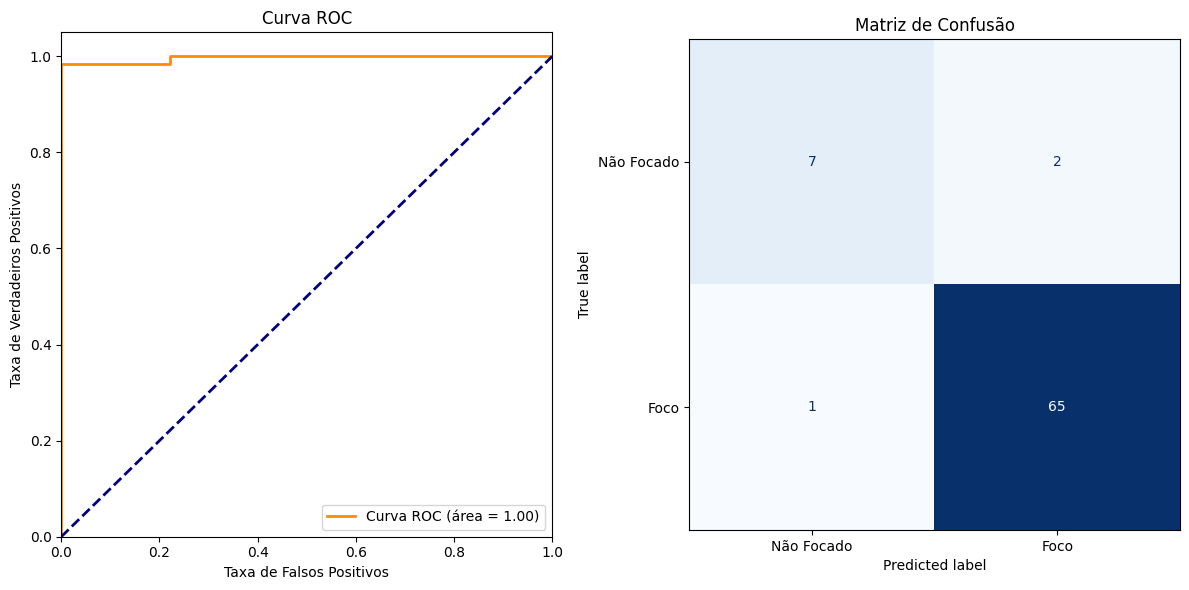

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Cálculo da Curva ROC
y_score = clf.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)

# Plot da Curva ROC
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')

# Cálculo e Plot da Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Focado', 'Foco'])

plt.subplot(1, 2, 2)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), colorbar=False)
plt.title('Matriz de Confusão')

plt.tight_layout()
plt.show()


### Definições dos Valores da Matriz

- **Verdadeiro Negativo (VN):** 7
  - Número de amostras que realmente são da classe "Não Focado" e foram corretamente classificadas como "Não Focado".

- **Falso Positivo (FP):** 2
  - Número de amostras que realmente são da classe "Não Focado" mas foram incorretamente classificadas como "Foco".

- **Falso Negativo (FN):** 1
  - Número de amostras que realmente são da classe "Foco" mas foram incorretamente classificadas como "Não Focado".

- **Verdadeiro Positivo (VP):** 65
  - Número de amostras que realmente são da classe "Foco" e foram corretamente classificadas como "Foco".

### Métricas de Desempenho

- **Precisão para "Não Focado":**

  A precisão para a classe "Não Focado" é 78%, o que indica que 78% das amostras classificadas como "Não Focado" são realmente da classe "Não Focado".

- **Precisão para "Foco":**

  A precisão para a classe "Foco" é 98%, o que indica que 98% das amostras classificadas como "Foco" são realmente da classe "Foco".

- **Recall para "Não Focado":**
- 
  O recall para a classe "Não Focado" é 88%, o que indica que 88% das amostras realmente "Não Focado" foram corretamente identificadas.

- **Recall para "Foco":**

  O recall para a classe "Foco" é 97%, o que indica que 97% das amostras realmente "Foco" foram corretamente identificadas.

### Conclusão

Com base nos resultados:

- O algoritmo SVM é muito eficaz na identificação dos períodos de "Foco", com uma alta precisão e recall para essa classe (98% e 97%, respectivamente).
- No entanto, o modelo é menos eficiente na identificação de períodos de "Não Focado", com uma precisão de 78% e recall de 88%. Isso sugere que o SVM tem mais dificuldades para classificar corretamente amostras da classe "Não Focado".

Esses resultados indicam que, embora o SVM seja excelente para detectar períodos de "Foco", pode ser necessário melhorar o desempenho na detecção de períodos de "Não Focado" para obter um equilíbrio melhor entre as classes.
